## Übung 7 - Lisa Mattrisch, Vanessa Schreck
# Logistic Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools

%matplotlib inline

In [500]:
def get_prob_correct(xdata, labels, beta):
    ###INPUT:
    #xdata:   matrix containing the datapoints as rows
    #labels:  vector containing corresponding labels
    #beta:    current beta-vector
    
    ###OUTPUT:
    #prob:    probability of xdata having label 'labels'
    
    scalar_product = xdata.dot(beta)
    prob = 1./(1+ np.exp(-labels* scalar_product ))
    return prob


def gradient(xdata, labels, beta):
    ###INPUT:
    #xdata:    datamatrix containing the datapoints as rows
    #labels:   vector containing corresponding labels
    #beta:     current beta-vector
    
    ###OUTPUT:
    #gradient: gradient of the likelihood
    
    temp_vec = labels*(1-get_prob_correct(xdata, labels, beta))
    summands = (xdata.T*temp_vec).T
    return sum(summands)
            

In [501]:
class Classifier:
    
    def __init__(self, step_size, max_iter = 1000, min_norm = .01, decision_threshold = 0.5):
        self.step_size = step_size
        self.max_iter  = max_iter
        self.min_norm  = min_norm
        self.decision_threshold = decision_threshold
        
        
    def fit(self, data_train, labels_train, data_test, labels_test, initial_beta = None):
        # Initialize an empty list to later store (in each iteration) the accuracy of the current beta
        self.progress  = []
        if initial_beta is None:
            initial_beta = np.zeros(len(data_train[0]))
        self.beta = initial_beta
        # Set a counter that counts the number of iterations (for termination of algo)
        counter = 0
        while counter < self.max_iter:
            # calculate new beta as in lecture
            beta_new = self.beta + self.step_size * gradient(data_train, labels_train, self.beta)
            
            # If the new beta doesn't deviate much from the old one: break.
            if np.linalg.norm(beta_new - self.beta) < self.min_norm and counter > 1:
                break
                
            # If all is good, overwrite the old beta with the new one.
            self.beta = beta_new
            # Calculate and store the accuracy (for plotting later)
            acc = self.calculate_accuracy(data_test, labels_test)
            self.progress.append(acc)
            counter += 1
        print('******* Ended after ' + str(counter) + ' iterations *******')
        
        
    def predict(self, data_test):
        # vector of probabilities of data belonging to class '1'
        prob = get_prob_correct(data_test, np.ones(len(data_test)), self.beta)
        # predict the new labels by comparing with the chosen threshold
        predicted_labels = (prob>self.decision_threshold)
        predicted_labels = 2*predicted_labels - 1   #go from labels 0/1 to -1/1
        return predicted_labels
              
        
    def calculate_accuracy(self, data_test, labels_test):
        # needs the test_data to have an assigned label
        predicted_labels = self.predict(data_test)
        num_correct = sum(predicted_labels == labels_test)
        acc = num_correct/ float(len(data_test))
        return acc
    
    
    def plot_stuff(self, data_test, labels_test, predicted_labels):
        ### Generate figure
        global fig
        fig = plt.figure( figsize=(14, 7) )
        
        ### Plot progress of classification accuracy
        plt.subplot(121)
        plt.plot(self.progress)
        plt.xlabel('number of iterations')
        plt.ylabel('accuracy')
        print('maximal accuracy is ' + str(max(self.progress)))
        
        ### Generate confusion matrix:
        conf_matrix = metrics.confusion_matrix(labels_test, predicted_labels, labels = [-1,1])
        norm_conf_matrix = conf_matrix.astype('float')/conf_matrix.sum(axis = 1)[:, np.newaxis]
        
        ### Plot confusion matrix:
        plt.subplot(122)
        plt.imshow(norm_conf_matrix,cmap=plt.cm.Blues, interpolation='nearest')
        plt.colorbar()
        plt.xlabel('predicted label')
        plt.ylabel('true label')
        plt.title('Confusion matrix\n')
        for i, j in itertools.product(range(norm_conf_matrix.shape[0]), 
                                      range(norm_conf_matrix.shape[1])):
            plt.text(j,
                     i,
                     format(norm_conf_matrix[i,j], '.3f'),
                     horizontalalignment = 'center',
                     color = 'white' if norm_conf_matrix[i,j] > .7 else 'black'
                    )

### Exercise 1

In [380]:
### load data
dataframe = pd.read_csv('spambase.txt', header = None)
data_array = np.array(dataframe)
xdata = data_array[:,:-1]
### add 1 as first coordinate to pos:
xdata = np.concatenate((np.ones((len(xdata),1)), xdata), axis=1)
### normalize data
xdata = ((xdata.T)/sum(xdata.T)).T

labels = data_array[:, -1]
labels = 2*labels - 1

### Divide data in train set and test set (80-20):
data_train, data_test, labels_train, labels_test = train_test_split(
    xdata, 
    labels,
    test_size=0.2,
    random_state=13
)

Generate Classifier object and fit & predict

******* Ended after 6752 iterations *******
maximal accuracy is 0.869706840391


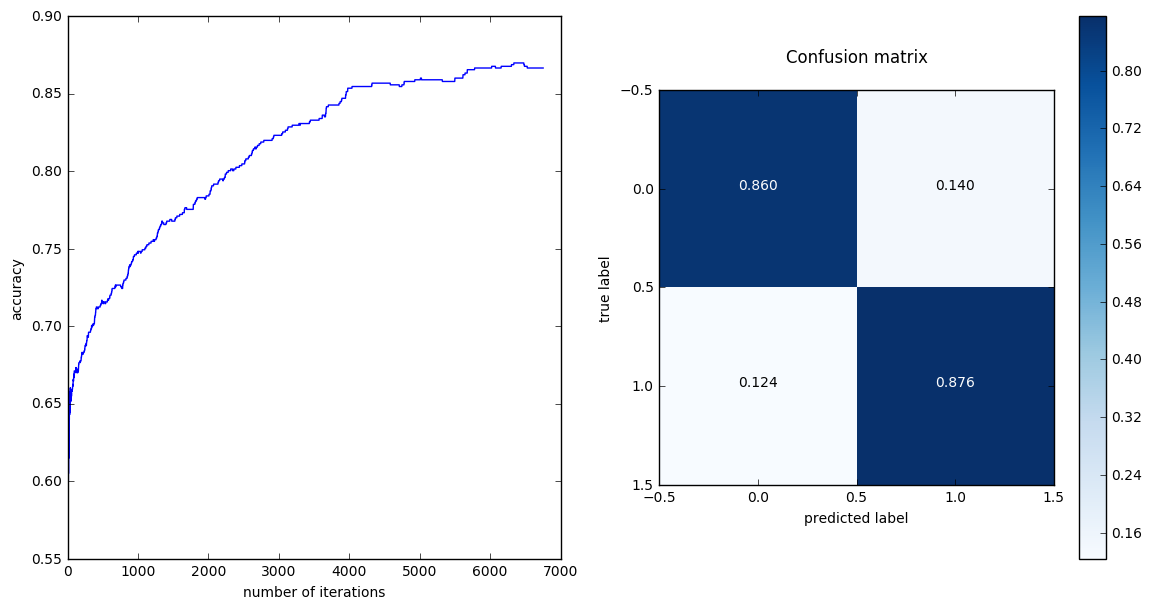

In [392]:
cl = Classifier(1./250, max_iter = 10000, min_norm = 0.01)
cl.fit(data_train, labels_train, data_test, labels_test)
predicted_labels = cl.predict(data_test)
cl.plot_stuff(data_test, labels_test, predicted_labels);

To bias the dicision in favor of non-spam (label $-1$) wie shift the threshold for predicting spam to $65\%$ instead of $50\%$ and obtain an accuracy of $\sim 84\%$. Now instead of $14\%$ only $6.2\%$ of the non-spam mails are labeled as spam.

******* Ended after 50000 iterations *******
maximal accuracy is 0.843648208469


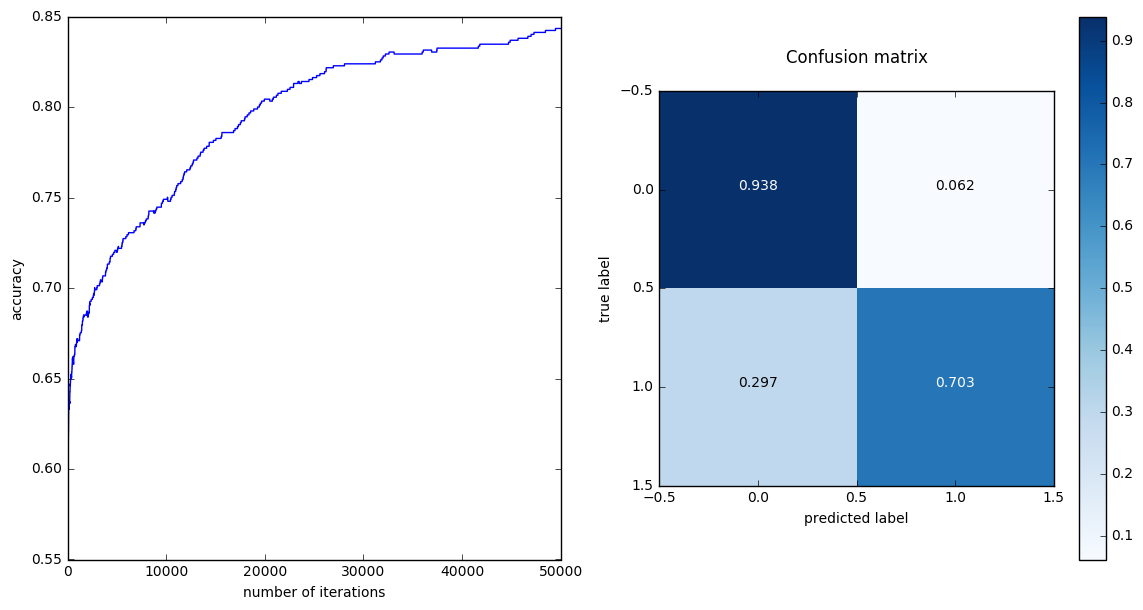

In [395]:
cl_shifted = Classifier(1./250, max_iter = 50000, min_norm = 0.001, decision_threshold = 0.65)
cl_shifted.fit(data_train, labels_train, data_test, labels_test)
predicted_labels = cl_shifted.predict(data_test)
cl_shifted.plot_stuff(data_test, labels_test, predicted_labels);

### Exercise 2

In [470]:
# Generate all possible data points and corresponding labels for and, or and xor
xdata_logic = np.array([[i,j]  for i,j in itertools.product([0,1], repeat = 2)])
labels_and = 2*np.array([sum(datapoint) == 2 for datapoint in xdata_logic]) - 1
labels_or = 2*np.array([sum(datapoint) > 0 for datapoint in xdata_logic]) - 1
labels_xor = 2*np.array([sum(datapoint) == 1 for datapoint in xdata_logic]) - 1
# append data points by 1 in 1. position
xdata_logic = np.concatenate((np.ones((len(xdata_logic),1)), xdata_logic), axis=1)

#### Classifier for AND

******* Ended after 355 iterations *******
maximal accuracy is 1.0


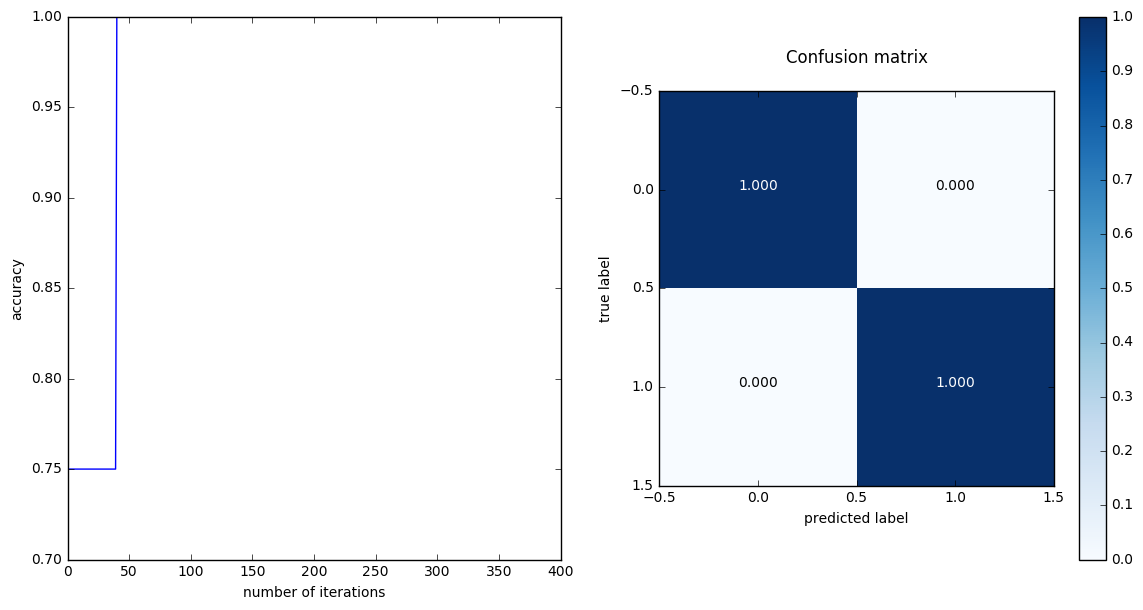

In [507]:
cl_and = Classifier(0.1, min_norm=0.01)
cl_and.fit(xdata_logic, labels_and, xdata_logic, labels_and)
predicted_labels = cl_and.predict(xdata_logic)
cl_and.plot_stuff(xdata_logic, labels_and, predicted_labels);

#### Classifier for OR

******* Ended after 287 iterations *******
maximal accuracy is 1.0


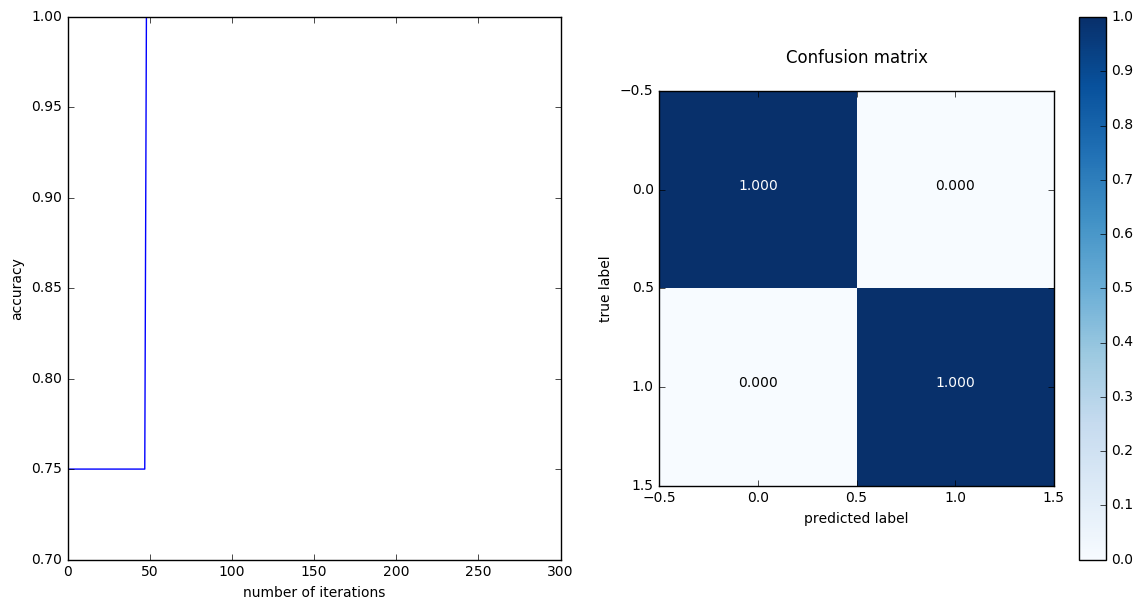

In [509]:
cl_or = Classifier(0.1, min_norm=0.01)
cl_or.fit(xdata_logic, labels_or, xdata_logic, labels_or)
predicted_labels = cl_or.predict(xdata_logic)
cl_or.plot_stuff(xdata_logic, labels_or, predicted_labels);

#### Classifier for XOR

******* Ended after 13 iterations *******
maximal accuracy is 0.75


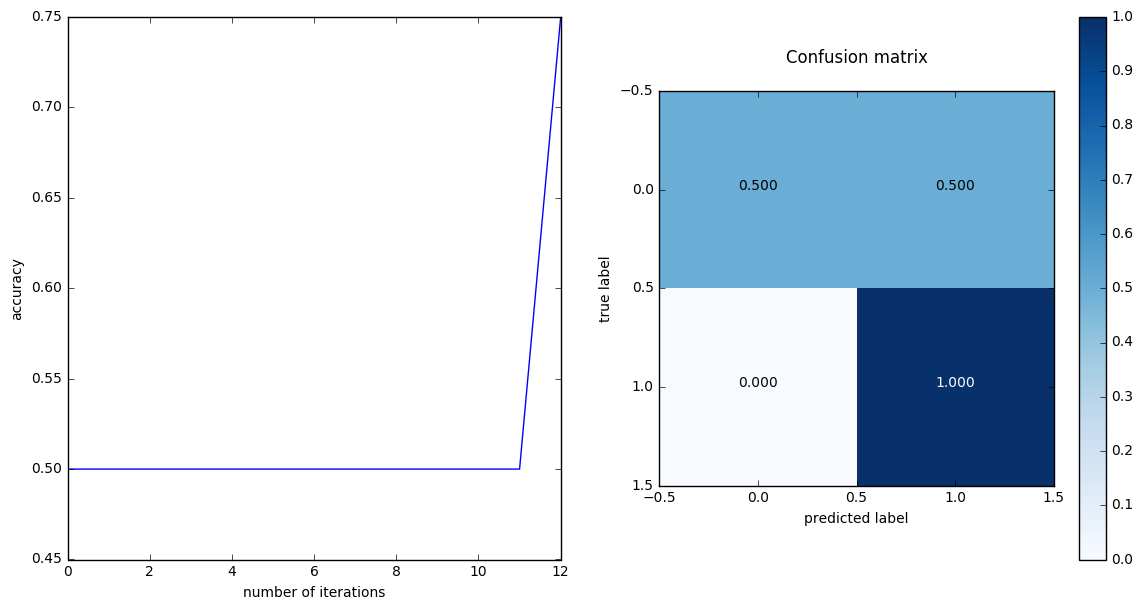

In [506]:
cl_xor = Classifier(0.1, min_norm=0.01)
beta = np.random.rand(len(xdata_logic[0]))
cl_xor.fit(xdata_logic, labels_xor, xdata_logic, labels_xor, initial_beta=beta)
predicted_labels = cl_xor.predict(xdata_logic)
cl_xor.plot_stuff(xdata_logic, labels_xor, predicted_labels);

The classifier for XOR can at best have an accuracy of $75\%$, because the classes are not linearly seperable.